In [766]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../my_project_dir/UpGrad"))
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures,LabelEncoder
from sklearn.model_selection import cross_val_score


train = pd.read_csv('../my_project_dir/UpGrad/bank-additional-full.csv', sep = ';')
train_set = train
train.shape

['bank-additional-full.csv']


(41188, 21)

In [767]:
train['y'] = train['y'].map( {'no': 0, 'yes': 1} ).astype(int)
train['contact'] = train['contact'].map( {'cellular': 0, 'telephone': 1} ).astype(int)

train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,1,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,1,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,1,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,1,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,1,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [768]:
#Checking the object types
train.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact             int64
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                   int64
dtype: object

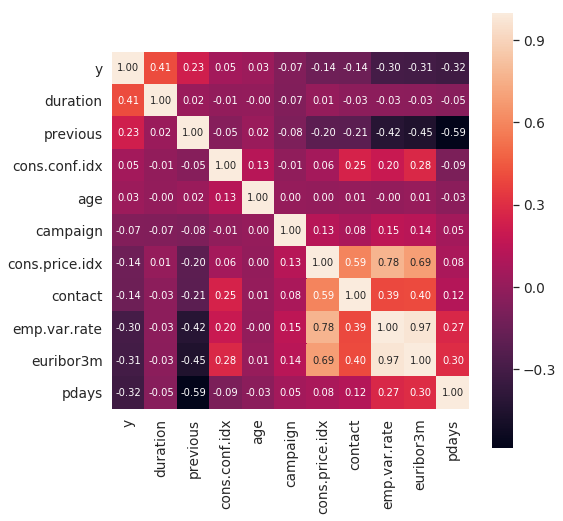

In [769]:
#Correlation Analysis

plt.subplots(figsize=(8,8))
corrmat = train.corr()
k = 11 #number of variables for heatmap
cols = corrmat.nlargest(k, 'y')['y'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


Since 'euribor3m' and 'emp.var.rate' are highly correlated we can keep only one of them. We can drop 'emp.var.rate' as it is also correlated to cons.price.idx to a good extent.

In [770]:
train = train.drop('emp.var.rate', axis = 1)

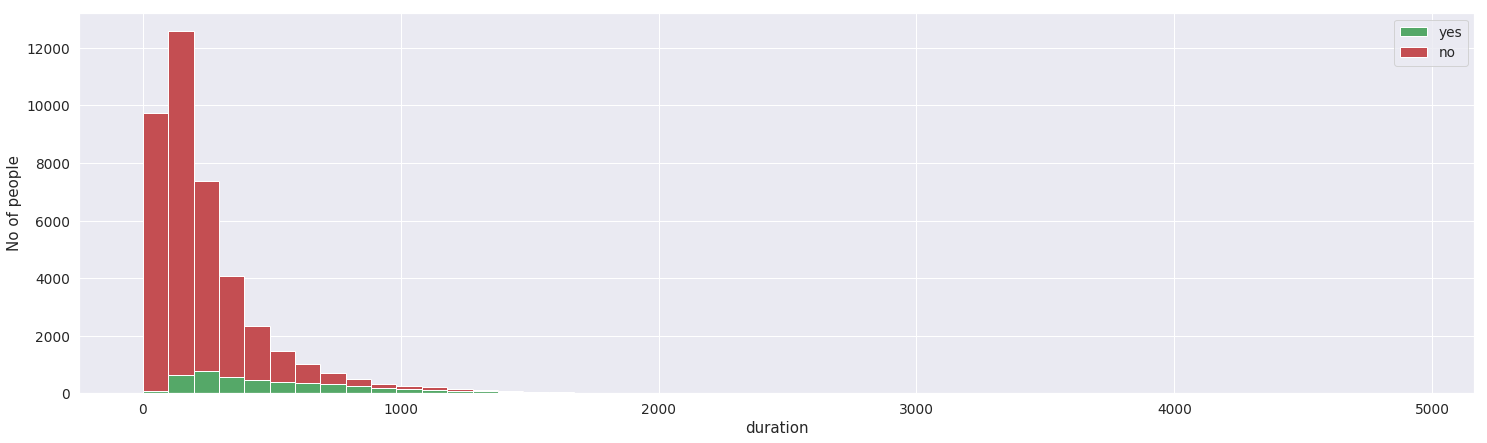

In [771]:
#Check how different attributes have an impact on the decision.
figure = plt.figure(figsize=(25, 7))
plt.hist([train[train['y'] == 1]['duration'], train[train['y'] == 0]['duration']],
         stacked=True, color = ['g','r'],
         bins = 50, label = ['yes','no'])
plt.xlabel('duration')
plt.ylabel('No of people')
plt.legend();

We can see that more no of people are likely to invest if the duration is higher. Hence to improve the no of prospects, we should try to improve the duration.
However, the duration of a call is also not known beforehand, hence it cannot be used as a means to predict wheather a target is will invest or not.
Hence we should ideally remove it to prepare a model for potential prospects.

In [772]:
train = train.drop('duration', axis = 1)

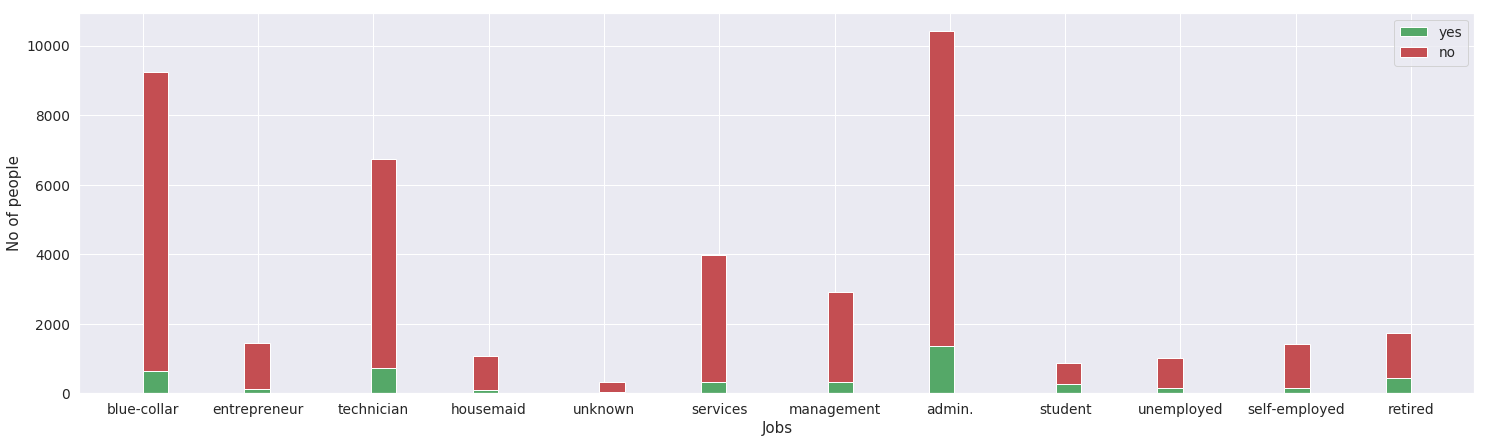

In [773]:
#Check how different attributes have an impact on the decision.
figure = plt.figure(figsize=(25, 7))
plt.hist([train[train['y'] == 1]['job'], train[train['y'] == 0]['job']],
         stacked=True, color = ['g','r'],
         bins = 50, label = ['yes','no'])
plt.xlabel('Jobs')
plt.ylabel('No of people')
plt.legend();

We can see 'housemaids' and 'entrepreneurs' have less affinity to invest. Hence to reduce the cost, we should market less to these classes.

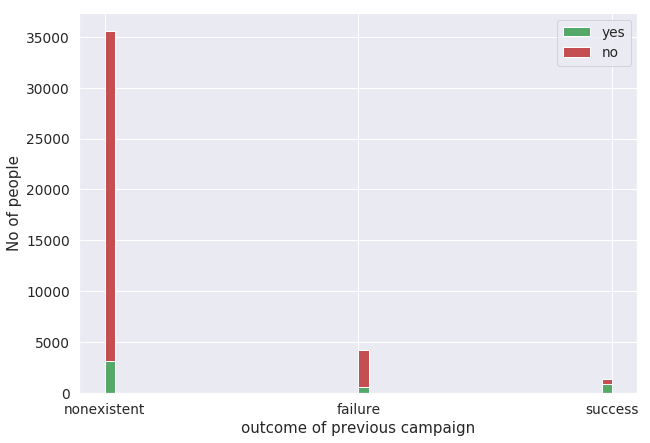

In [774]:
figure = plt.figure(figsize=(10, 7))
plt.hist([train[train['y'] == 1]['poutcome'], train[train['y'] == 0]['poutcome']],
         stacked=True, color = ['g','r'],
         bins = 50, label = ['yes','no'])
plt.xlabel('outcome of previous campaign')
plt.ylabel('No of people')
plt.legend();


We can see that if the outcome of the previous campaign was a success then it is more likey to be a success this time as well

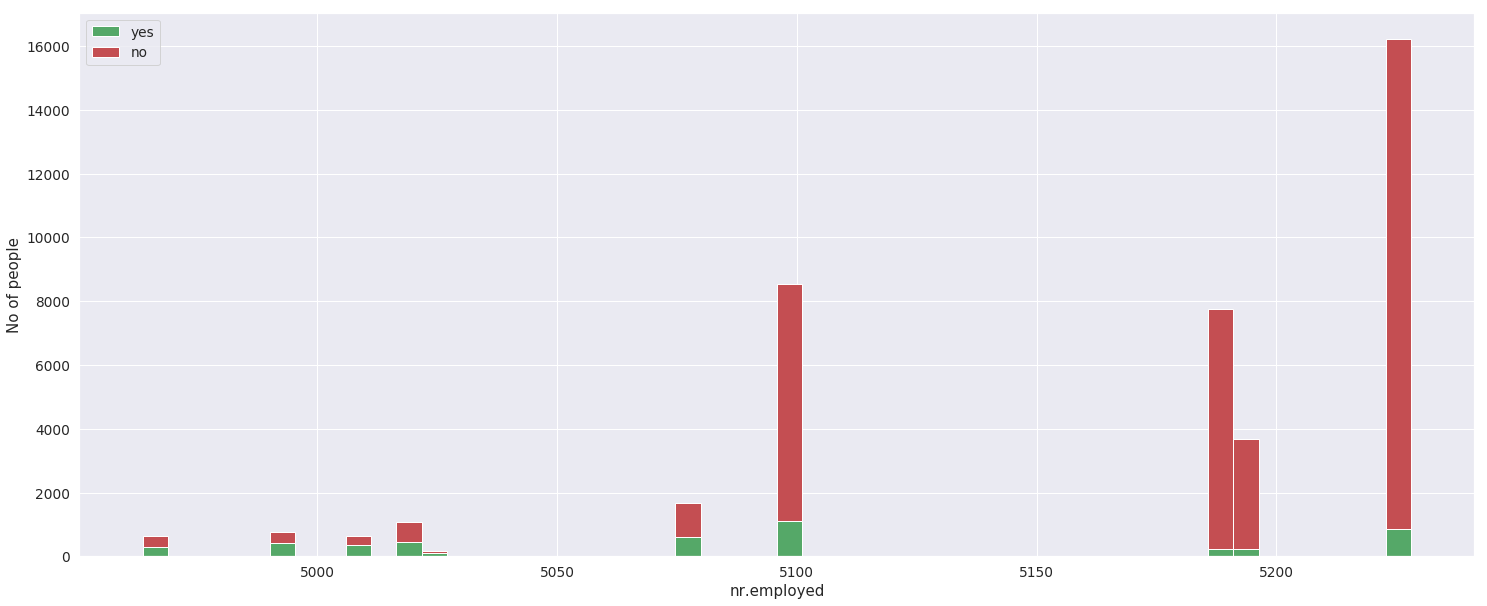

In [775]:
figure = plt.figure(figsize=(25, 10))
plt.hist([train[train['y'] == 1]['nr.employed'], train[train['y'] == 0]['nr.employed']],
         stacked=True, color = ['g','r'],
         bins = 50, label = ['yes','no'])
plt.xlabel('nr.employed')
plt.ylabel('No of people')
plt.legend();


We can see that more no of people employed doesn't relate to improvent in the no of prospects. Hence we can reduce the no of people employed to a certain extent as we can see less no of people employed have a better ratio.

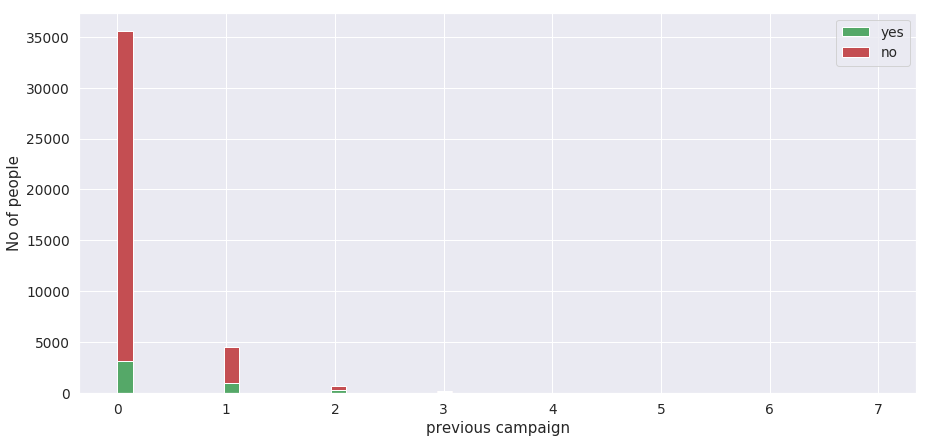

In [776]:
#Check how different attributes have an impact on the decision.
figure = plt.figure(figsize=(15, 7))
plt.hist([train[train['y'] == 1]['previous'], train[train['y'] == 0]['previous']],
         stacked=True, color = ['g','r'],
         bins = 50, label = ['yes','no'])
plt.xlabel('previous campaign')
plt.ylabel('No of people')
plt.legend();

The data corresponding to previous campaign is very skewed. We do not have much information for contacts made that are greater than 2 hence we cannot make any proper conclusions regarding this.

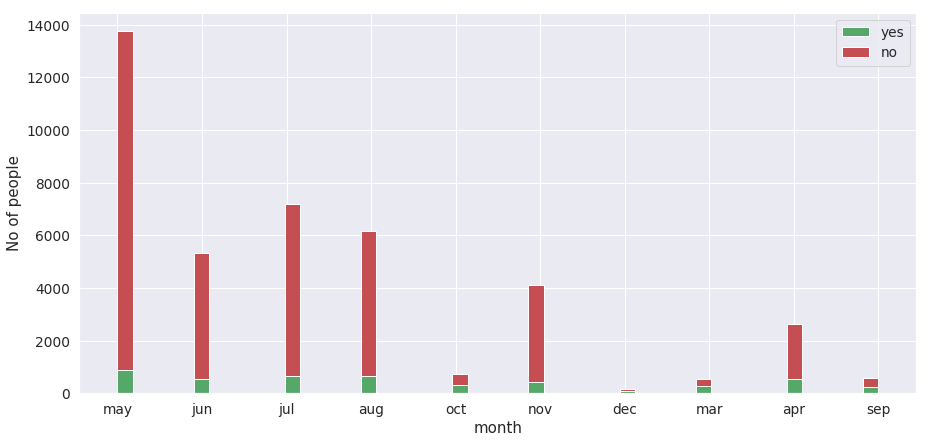

In [777]:
figure = plt.figure(figsize=(15, 7))
plt.hist([train[train['y'] == 1]['month'], train[train['y'] == 0]['month']],
         stacked=True, color = ['g','r'],
         bins = 50, label = ['yes','no'])
plt.xlabel('month')
plt.ylabel('No of people')
plt.legend();

The ratio of prospects is low in the months of 'May', 'June', 'July' and 'August' as compared to others. Moreover, the months of 'Oct' and 'Dec'have a higher ratio of the no. of prospects.
This suggests that more people are likely to invest in 'Winters' than in 'Summers'.

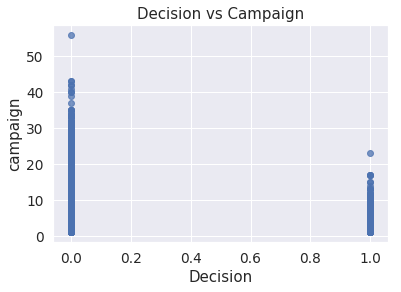

In [778]:
campaign = train['campaign']
decision = train['y']

plt.scatter(decision, campaign, alpha=.75,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Decision')
plt.ylabel('campaign')
plt.title('Decision vs Campaign')
plt.show()

It shows that the no of campaigns after 20 are useless. Hence no customer should be approached more than 20 times. Moreover, we can find the efficiency of calls that are made. 

In [779]:
#Total conversion ratio 
ratio = sum(train['y'] == 1)/sum(train['campaign'])
ratio

0.043875408967982296

In [780]:
#Lets optimize on the basis campaign

# Now let's see efficiancy on every additional call
print ("Nth Call \t Efficiency")
for i in range(1,30):
    goo = sum(train.loc[train['campaign']==i]['y']==1) / float(train.loc[train['campaign'] >= i].shape[0])
    print (str((i))+" \t\t "+str(goo))

Nth Call 	 Efficiency
1 		 0.05584150723511702
2 		 0.05143124097511254
3 		 0.04423551171393342
4 		 0.03261296660117878
5 		 0.024077046548956663
6 		 0.022156573116691284
7 		 0.015793848711554447
8 		 0.009566685424873381
9 		 0.012345679012345678
10 		 0.010968921389396709
11 		 0.01380897583429229
12 		 0.004335260115606936
13 		 0.007054673721340388
14 		 0.002105263157894737
15 		 0.0049261083743842365
16 		 0.0
17 		 0.013157894736842105
18 		 0.0
19 		 0.0
20 		 0.0
21 		 0.0
22 		 0.0
23 		 0.008620689655172414
24 		 0.0
25 		 0.0
26 		 0.0
27 		 0.0
28 		 0.0
29 		 0.0


We can see that the efficiency decreases after every call made.
After the 7th call, we can see the efficiency decreases considerably (17 calls can be treated as outlier as it doesn't follow the trend). Hence we can reduce the marketing cost by not calling a person more than 7 times

In [781]:
#Optimising the no of calls made

#Calculate how many calls were made in total
total_calls = sum(train['campaign'])
print(total_calls)

# Calculate how many calls were made after the 7th call
calls_more_than7 = sum(train[train['campaign']> 7 ]['campaign']) - 7*train[train['campaign']> 7 ].shape[0]
print(calls_more_than7)


105754
9634


In [782]:
#Reduction in marketing cost if more than 7 calls are not made

reduction=100*(calls_more_than7/total_calls)
print(reduction)

#Total conversions 
total_conversions = float(train[train['y'] == 1].shape[0])
print(total_conversions)

#Conversions if not more that 7 calls are made
conversions_less_7 = float(train[(train['campaign'] <= 7) & (train['y']==1)].shape[0])
print(conversions_less_7)

9.10982090511943
4640.0
4567.0


In [783]:
#Conversion percentage if calls were reduced
conversion_percent=100 * (conversions_less_7/total_conversions)
print(conversion_percent)

98.42672413793103


We can see that we can reduce the marketing price by 9.1% while still keeping a conversion percentage of 98.4% by limiting the no of calls made to a consumer to 7.

In [784]:
#Conversion ratio in different months

months = train['month'].unique()

print (train['month'].value_counts())
ratio = sum(train['y'] == 1)/(train['month'].value_counts())
print (ratio)

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64
may     0.336989
jul     0.646780
aug     0.751052
jun     0.872508
nov     1.131431
apr     1.762918
oct     6.462396
sep     8.140351
mar     8.498168
dec    25.494505
Name: month, dtype: float64


We can see that the no. of calls made in 'May' are the least efficient even though they are very high as compared to the rest, but we cannot be sure that these calls necessarily correspond to a poor ratio as we do not know if these customers have previously been contacted or not.
We can only say that to reduce the market cost, calls should be reduced in May. 
Also, 'Dec' have the highest conversion ratio so we can say that if we increased the calls made during 'Dec', we can improve the no. of cunsumers.

Conversion ratio in different months

In [785]:
#Calls in May
callinmay = (train['month'] == 'may').value_counts()[True]
print (callinmay)

#Total calls
total = sum(train['month'].value_counts())
print (total)

reduction = 100 * (callinmay/total)
print (reduction)

13769
41188
33.429639700883754


In [786]:
#Total
print(total_conversions)

#Conversions in may
conversions_may = float(train[(train['month'] == 'may') & (train['y']==1)].shape[0])
print(conversions_may)

#Conversion percentage if calls were reduced
conversion_percent=100 * (conversions_may/total_conversions)
print(conversion_percent)

4640.0
886.0
19.094827586206897


We can see if we made no calls in the month of May, we can reduce the marketing cost by 33% but it will also decrease the consumer conversion by 16%.
Hence we cannot say anything regarding the conversion in relation to different months.

In [787]:
#Removing columns with a large no of missing values
    
print (train['default'].value_counts())
print (train['pdays'].value_counts())

#Since both of these have very large no. of missing data, we can remove them
train = train.drop('default', axis = 1)
train = train.drop('pdays', axis = 1)


no         32588
unknown     8597
yes            3
Name: default, dtype: int64
999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64


Modelling

In [788]:
#Mean normalising columns

for i in train.columns:
    if train[i].dtype == 'float64':
        train[i] = (train[i] - train[i].mean())/(train[i].std())


In [789]:
#Fill missing Values by Imputing the unkown Values with mode

header = train.columns

from sklearn.impute import SimpleImputer
imp_mode = SimpleImputer(missing_values='unknown', strategy='most_frequent')
train_transformed = imp_mode.fit_transform(train)

train = pd.DataFrame(train_transformed, columns = header)

train.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,1,may,mon,1,0,nonexistent,0.722714,0.886436,0.712451,0.331676,0
1,57,services,married,high.school,no,no,1,may,mon,1,0,nonexistent,0.722714,0.886436,0.712451,0.331676,0
2,37,services,married,high.school,yes,no,1,may,mon,1,0,nonexistent,0.722714,0.886436,0.712451,0.331676,0
3,40,admin.,married,basic.6y,no,no,1,may,mon,1,0,nonexistent,0.722714,0.886436,0.712451,0.331676,0
4,56,services,married,high.school,no,yes,1,may,mon,1,0,nonexistent,0.722714,0.886436,0.712451,0.331676,0


In [790]:
#Removing rows where 'campaign' is greater than 7 to check if it corresponds to 'better or similar conversion'

train.drop(train[(train["campaign"]>7)].index,inplace=True)
                 
#&(train["SalePrice"]<300000)].index,inplace=True)
train.shape

#Drop labels

y = train['y']
train = train.drop('y', axis = 1)
y.unique()
y = y.astype('int')

In [791]:
from sklearn.feature_extraction import DictVectorizer

train_dict = train.T.to_dict().values()

vec  = DictVectorizer()
train_array = vec.fit_transform(train_dict).toarray()
header = vec.get_feature_names()

train = pd.DataFrame(train_array, columns = header)


train.head()

,age,campaign,cons.conf.idx,cons.price.idx,contact,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,...,month=mar,month=may,month=nov,month=oct,month=sep,nr.employed,poutcome=failure,poutcome=nonexistent,poutcome=success,previous
0,56.0,1.0,0.886436,0.722714,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.331676,0.0,1.0,0.0,0.0
1,57.0,1.0,0.886436,0.722714,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.331676,0.0,1.0,0.0,0.0
2,37.0,1.0,0.886436,0.722714,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.331676,0.0,1.0,0.0,0.0
3,40.0,1.0,0.886436,0.722714,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.331676,0.0,1.0,0.0,0.0
4,56.0,1.0,0.886436,0.722714,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.331676,0.0,1.0,0.0,0.0


Classification

Note: Since the data is very skewed, accuracy is not a good measure to estimate wheather a customer will invest or not. Here we will use F1 score.


In [792]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(train, y, test_size=0.2, random_state=42)


In [793]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(train_x,train_y)
pred = lr.predict(test_x)

acc = accuracy_score(test_y, pred)
print(acc)

#Classification Report

print(classification_report(test_y,pred))

/home/vaibhav/my_project_dir/my_project_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8986426487377902
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6984
           1       0.66      0.23      0.34       899

   micro avg       0.90      0.90      0.90      7883
   macro avg       0.79      0.61      0.64      7883
weighted avg       0.88      0.90      0.88      7883



In [794]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 200).fit(train_x,train_y)

pred = rfc.predict(test_x)
#Classification Report

print(classification_report(test_y,pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      6984
           1       0.53      0.30      0.38       899

   micro avg       0.89      0.89      0.89      7883
   macro avg       0.72      0.63      0.66      7883
weighted avg       0.87      0.89      0.88      7883



In [795]:
#Classification
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(train_x, train_y, early_stopping_rounds=5, 
             eval_set=[(test_x, test_y)], verbose=False)
pred = xgb.predict(test_x)

result_val = cross_val_score(xgb,train_x, train_y, cv=5).mean()
print (result_val)

print(classification_report(test_y,pred))

0.8963461808838329
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      6984
           1       0.74      0.19      0.30       899

   micro avg       0.90      0.90      0.90      7883
   macro avg       0.82      0.59      0.62      7883
weighted avg       0.89      0.90      0.87      7883

